# 잠재 요인 협업 필터링
#### 잠재 요인 필터링은 사용자-아이템 평점 매트릭스 속에 숨어 있는 잠재 요인을 추출해 추천 예측을 할 수 있는 기법이다.
#### 대규모 다차원 행렬을 SVD와 같은 차원 감소 기법으로 분해하는 과정에서 잠재 요인을 추출하는데, 이러한 기법을 행렬 분해라고 한다.

#### 사용자-아이템 평점 행렬 데이터만을 이용해 말 그대로 잠재 요인을 끄집어 내는 것을 의미한다. 하지만 잠재 요인이 어떤 것인지 명확히 정의할 수 없다.
#### 하지만 이러한 잠재 요인을 기반으로 다차원 희소 행렬인 사용자-아이템 행렬 데이터를 저차원 밀집 행렬의 사용자-아이템 행렬과 아이템-잠재 요인 행렬의 전치 행렬(즉, 잠재 요인-아이템 행렬)로 분해할 수 있으며, 이렇게 분해된 두 행렬의 내적을 통해 새로운 예측 사용자-아이템 평점 행렬 데이터를 만든다.
#### 그래서, 사용자가 아직 평점을 부여하지 않은 아이템에 대한 예측 평점을 생성하는 것이다.
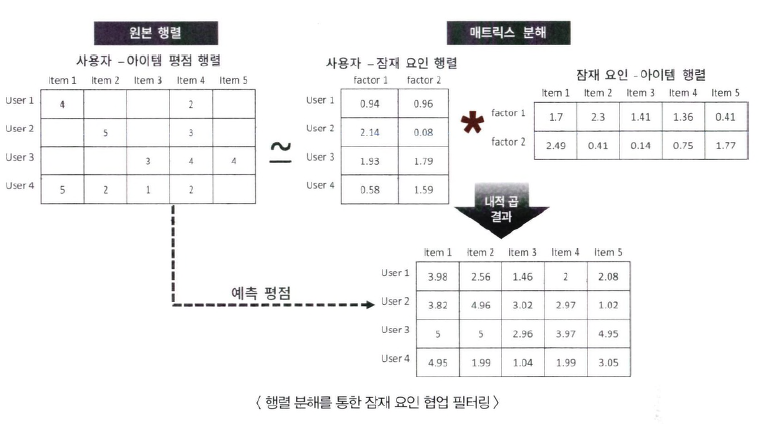

#### 예를 들어, 사용자-잠재 요인 행렬은 사용자의 영화 장르에 대한 선호도로, 아이템-잠재 요인 행렬은 영화의 장르별 특성값으로 정의할 수 있다.
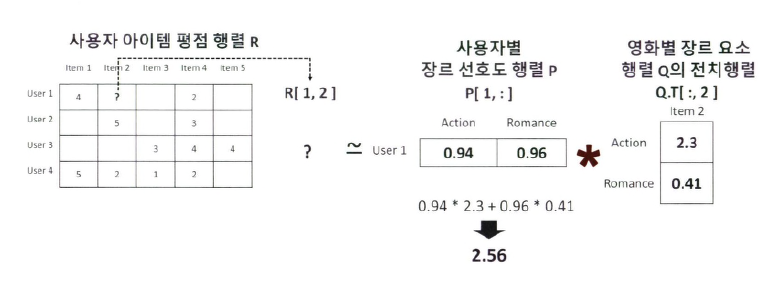
#### 이처럼 사용자-아이템 평점 행렬과 같이 다차원의 매트릭스를 저차원의 매트릭스로 분해하는 기법을 행렬 분해라고 한다.

## 행렬 분해의 이해
#### 행렬 분해는 다차원의 매트릭스를 저차원 매트릭스로 분해하는 기법으로 대표적은 SVD, NMF 등이 있다.
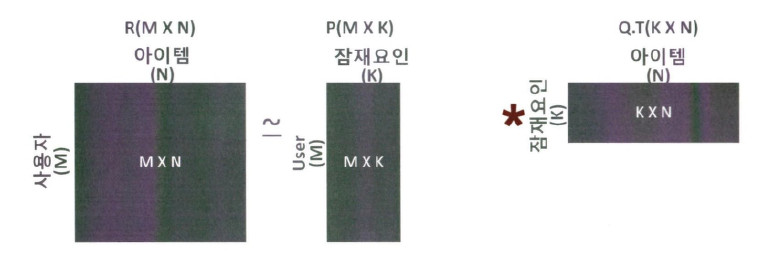
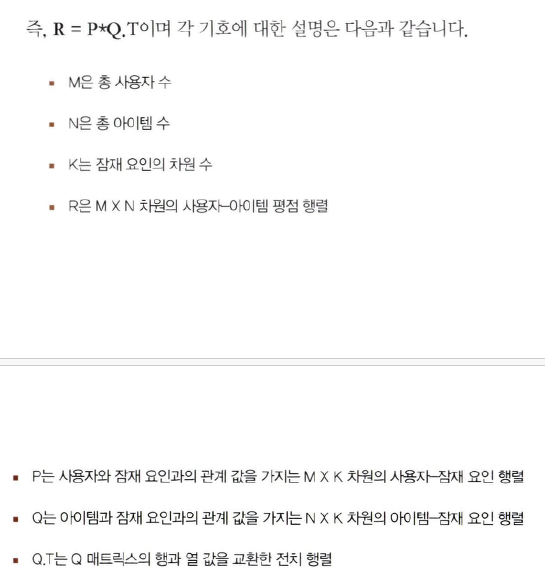

#### 행렬 분해는 주로 SVD 방식을 이용하지만, SVD는 널 값이 없는 행렬에만 적용 가능하다. 그래서, 확률적 경사 하강법이나 ALS 방식을 이용해 SVD를 수행한다.

## 확률적 경사 하강법을 이용한 행렬 분해
#### P와 Q행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P와 Q를 유추해내는 것이다.
#### 쉽게 정리하자면 아래와 같다.
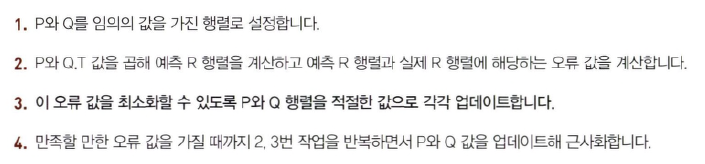

#### 실제 값과 예측값의 오류 최소화와 L2 규제를 고려한 비용 함수식은 다음과 같다.
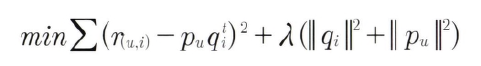

#### 그리고 위의 비용 함수를 최소화하기 위해서 새롭게 업데이트되는 P와 Q는 다음과 같이 계산할 수 있다.
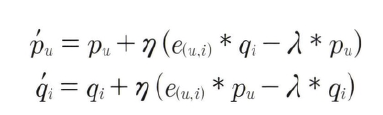
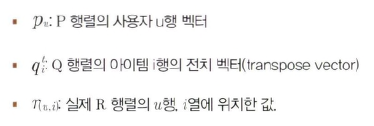
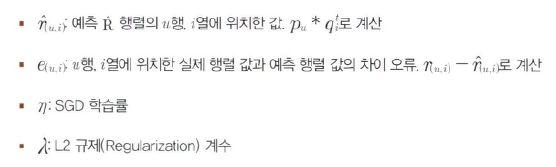

#### SGD를 이용해 행렬 분해를 수행해보자.
#### 원본 행렬 R 및 R을 분해할 P와 Q를 임의의 정규분포를 가진 랜덤값으로 초기화

In [1]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3 설정. 
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN ],
              [np.NaN, 5, np.NaN, 3, 1 ],
              [np.NaN, np.NaN, 3, 4, 4 ],
              [5, 2, 1, 2, np.NaN ]])

num_users, num_items = R.shape
K=3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))
print("P:",P)
print("Q:",Q)

P: [[ 0.54144845 -0.2039188  -0.17605725]
 [-0.35765621  0.28846921 -0.76717957]
 [ 0.58160392 -0.25373563  0.10634637]
 [-0.08312346  0.48736931 -0.68671357]]
Q: [[-0.1074724  -0.12801812  0.37792315]
 [-0.36663042 -0.05747607 -0.29261947]
 [ 0.01407125  0.19427174 -0.36687306]
 [ 0.38157457  0.30053024  0.16749811]
 [ 0.30028532 -0.22790929 -0.04096341]]


#### 비용계산 함수를 생성. 분해된 행렬 P와 Q.T를 내적하여 예측 행렬 생성하고 실제 행렬에서 널이 아닌 값의 위치에 있는 값만 예측 행렬의 값과 비교하여 RMSE값을 계산하고 반환

In [2]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

#### 경사하강법에 기반하여 P와 Q의 원소들을 업데이트 수행 

In [3]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장. 
non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

steps=1000
learning_rate=0.01
r_lambda=0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트. 
for step in range(steps):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 50) == 0 :
        print("### iteration step : ", step," rmse : ", rmse)

### iteration step :  0  rmse :  3.2388050277987723
### iteration step :  50  rmse :  0.48767231013696477
### iteration step :  100  rmse :  0.1564340384819248
### iteration step :  150  rmse :  0.07455141311978032
### iteration step :  200  rmse :  0.0432522679857931
### iteration step :  250  rmse :  0.029248328780879088
### iteration step :  300  rmse :  0.022621116143829344
### iteration step :  350  rmse :  0.01949363619652533
### iteration step :  400  rmse :  0.018022719092132503
### iteration step :  450  rmse :  0.01731968595344277
### iteration step :  500  rmse :  0.01697365788757103
### iteration step :  550  rmse :  0.016796804595895533
### iteration step :  600  rmse :  0.01670132290188455
### iteration step :  650  rmse :  0.016644736912476654
### iteration step :  700  rmse :  0.016605910068210192
### iteration step :  750  rmse :  0.01657420047570466
### iteration step :  800  rmse :  0.016544315829215932
### iteration step :  850  rmse :  0.01651375177473506
### itera

In [4]:
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


#### 원본 행렬과 비교해 널이 아닌 값은 큰 차이가 나지 않으며, 널인 값은 새로운 예측값이 채워졌다.